In [ ]:
# Domain adaptive lesion classification
# Article ID: MRM28794
# Article DOI: 10.1002/mrm.28794
# Article: Domain Adaptive and Fully Automated Carotid Artery Atherosclerotic Lesion Detection using an Artificial Intelligence Approach (LATTE) on 3D MRI
# Journal: Magnetic Resonance in Medicine
# Code adpted from https://github.com/pumpikano/tf-dann
# By Li Chen
# 4/2/2021

In [15]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import tensorflow as tf

import keras
from keras.backend.tensorflow_backend import set_session
config2 = tf.ConfigProto()
config2.gpu_options.allow_growth = True
set_session(tf.Session(config=config2))

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__,keras.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.15.0 2.3.1


In [4]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

# Load data

In [10]:
#project folder for LATTE
latte_result_dir = r'//DESKTOP4/Dtensorflow\LiChen\3DM\LATTE\results/'

#source domain, originally trained dataset
source_config = {'pjname':'CAREIIMERGE', 'datadir':r'X:\trials\3dmerge_deep_learning_for_lesion_detection\images',
                 'fromvts':1, 'vtsseq':'S101', 'GTSRC' : 'READCSVALL', 'INCLUDELIST':['P102', 'P128', 'P130', 'P158', 'P182', 'P196', 'P20', 'P21', 'P237', 'P252', 'P272', 'P285', 'P347', 'P376', 'P379', 'P388', 'P41', 'P438', 'P458', 'P470', 'P481', 'P483', 'P495', 'P503', 'P504', 'P530', 'P557', 'P573', 'P576', 'P651', 'P657', 'P664', 'P673', 'P69', 'P709', 'P711', 'P723', 'P732', 'P742', 'P789', 'P80', 'P855', 'P890', 'P891', 'P910', 'P935', 'P937', 'P944', 'P945', 'P951', 'P959', 'P961', 'P967', 'P975']}
source_pjname = source_config['pjname']
source_cdir = latte_result_dir+'/'+source_pjname
source_config['cdir'] = source_cdir

#target domain, new dataset without labels (labels are provided here for only evaluation purpose)
target_config = {'pjname':'RenjiMERGE', 'datadir':r'Y:\Li Chen\RenjiMERGE', 'fromvts':0, 'GTSRC' : 'READCSVALL'}
target_pjname = target_config['pjname']
target_cdir = latte_result_dir+'/'+target_pjname
target_config['cdir'] = target_cdir

#load pilist
if 'INCLUDELIST' in source_config:
    source_pilist = source_config['INCLUDELIST']
else:
    source_pilist = os.listdir(latte_result_dir+'/'+source_config['pjname']+'/3Dmergelist')
target_pilist = os.listdir(latte_result_dir+'/'+target_config['pjname']+'/3Dmergelist')
if 'EXCLUDELIST' in target_config:
    target_pilist = list(set(target_pilist) - set(target_config['EXCLUDELIST']))
    print('excluded',target_config['EXCLUDELIST'])
    
print('source cases',len(source_pilist),'target cases',len(target_pilist))

source cases 54 target cases 76


In [12]:
#pre-load validation set 
from db import data_generator, load_patch

#last XX cases from the source dataset
val_arr, val_label, val_src = load_patch(source_pilist[-2:],source_config,skip=10,load_gt=True,load_src=True)

# optional
#test_arr, test_label = load_patch(target_pilist[-10:],target_config,skip=10,load_gt=False)
#debug
test_arr, test_label, test_src = load_patch(target_pilist[-2:],target_config,skip=10,load_gt=True,load_src=True)

In [13]:
val_arr.shape,val_label.shape,len(val_src)

((42, 64, 64, 5, 2), (42,), 42)

(array([ 9.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0., 10.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

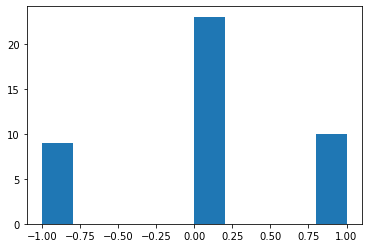

In [16]:
#check histogram
plt.hist(val_label)

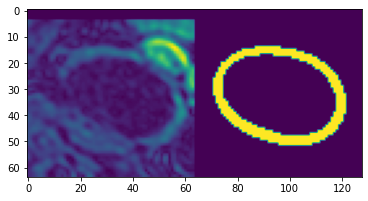

In [17]:
#check slice
plt.imshow(np.hstack([val_arr[2,:,:,3,0],val_arr[2,:,:,3,1]]))

# Train

In [21]:
taskname='VWClass8-2-Base'
cdir = os.getcwd()
resultdir = '//DESKTOP4/Dtensorflow/LiChen/3DM/LATTE/results/'
newpath = os.path.join(cdir,taskname)
if not os.path.exists(newpath):
    os.makedirs(newpath)
    print('create new folder'+newpath)
    
cfg = {}
#num GPUs
cfg['nGPU']=1
#patch size
cfg['patch_height'] = 64
cfg['patch_width'] = 64
cfg['depth'] = 5
cfg['channel'] = 2
cfg['cdir'] = cdir
cfg['resultdir'] = resultdir
cfg['types'] = 3
cfg['LABELS'] = ['Normal Artery','Early Lesion','Advanced Lesion','Unlabeled']

create new folderU:\LiChen\3DM\LATTE\DANN\VWClass8-2-Base


In [23]:
#training parameters
enable_dann = True
n_iterations = 15000
batch_size = 64

best_val = 0
best_test = 0
best_auc_adv = 0
best_auc_all = 0

from model import build_models

model, source_classification_model, domain_classification_model, embeddings_model = build_models(cfg)

from keras.utils import to_categorical
#y_class_dummy = np.ones((len(train.xarray), 2))
y_adversarial_1 = to_categorical(np.array(([1] * batch_size + [0] * batch_size)))
y_adversarial_2 = to_categorical(np.array(([0] * batch_size + [1] * batch_size)))

sample_weights_class = np.array(([1] * batch_size + [0] * batch_size))
sample_weights_adversarial = np.ones((batch_size * 2,))

S_batches = data_generator(source_pilist,source_config,batch_size,load_gt=True)
T_batches = data_generator(target_pilist,target_config,batch_size,load_gt=False)

In [24]:
from eval import getauc, decidelesion
from sklearn.metrics import accuracy_score

for i in range(n_iterations):

    X0, y0 = next(S_batches)
    X1, y1 = next(T_batches)
    
    sample_weights_class = np.array(([1] * batch_size + [0] * batch_size))
        
    X_adv = np.concatenate([X0, X1])
    y_class = np.concatenate([y0, np.zeros_like(y0)])

    adv_weights = []
    for layer in model.layers:
        if (layer.name.startswith("do")):
            adv_weights.append(layer.get_weights())

    if(enable_dann):
        # note - even though we save and append weights, the batchnorms moving means and variances
        # are not saved throught this mechanism 
        stats = model.train_on_batch(X_adv, [y_class, y_adversarial_1],
                                 sample_weight=[sample_weights_class, sample_weights_adversarial])

        k = 0
        for layer in model.layers:
            if (layer.name.startswith("do")):
                layer.set_weights(adv_weights[k])
                k += 1

        class_weights = []


        for layer in model.layers:
            if (not layer.name.startswith("do")):
                class_weights.append(layer.get_weights())

        stats2 = domain_classification_model.train_on_batch(X_adv, [y_adversarial_2])

        k = 0
        for layer in model.layers:
            if (not layer.name.startswith("do")):
                layer.set_weights(class_weights[k])
                k += 1

    else:
        #if i%10==1:
            #plt.imshow(X0[0,:,:,1:4,0])
            #plt.title(y0[0])
            #plt.show()
        source_classification_model.train_on_batch(X0,y0)


    if ((i + 1) % 10 == 0):
        print(i)
        y_val_pred = source_classification_model.predict(val_arr)
        #decidelesion is not accurate. threshold unknown
        y_val_hat_t = [decidelesion(y_val_pred[i,0],-0.5,0.5)[0] for i in range(len(y_val_pred))]
        acc_val = accuracy_score(val_label, y_val_hat_t)
        
        y_test_pred = source_classification_model.predict(test_arr)
        y_test_hat_t = [decidelesion(y_test_pred[i,0],-0.5,0.5)[0] for i in range(len(y_test_pred))]
        acc_test = accuracy_score(test_label, y_test_hat_t)
        
        #test_label -1,0,1, getauc needs 1,2,3
        auc_adv, auc_all = getauc(y_test_pred, test_label+2)
        
        print("Iteration %d, val accuracy =  %.3f, target accuracy = %.3f. auc_adv = %.3f, auc_all = %.3f"%\
              (i, acc_val, acc_test, auc_adv, auc_all))
        
        if ((i + 1) % 100 == 0):
            model.save(taskname+'/Addweights%d-%.3f-%.3f.hdf5'%(i,auc_all,auc_adv))
        else:
            if best_val<acc_val:
                best_val = acc_val 
                print('save best acc_val')
                model.save(taskname+'/Addweights%d-%.3f-%.3f-%.3f-%.3f.hdf5'%(i,acc_val,acc_test,auc_all,auc_adv))
            elif best_test<acc_test:
                best_test = acc_test 
                print('save best acc_test')
                model.save(taskname+'/Addweights%d-%.3f-%.3f-%.3f-%.3f.hdf5'%(i,acc_val,acc_test,auc_all,auc_adv))
            elif best_auc_adv<auc_adv:
                best_auc_adv = auc_adv
                print('save best auc_adv')
                model.save(taskname+'/Addweights%d-%.3f-%.3f-%.3f-%.3f.hdf5'%(i,acc_val,acc_test,auc_all,auc_adv))
            elif best_auc_all<auc_all:
                best_auc_all = auc_all
                print('save best auc_all')
                model.save(taskname+'/Addweights%d-%.3f-%.3f-%.3f-%.3f.hdf5'%(i,acc_val,acc_test,auc_all,auc_adv))

P102
0516064

P128
P130
9


NameError: name 'accuracy_score' is not defined

In [ ]:
# pick a best model from training results
model.load_weights(taskname+'/Addweights839-0.411-0.208-0.681-0.820.hdf5')

In [ ]:
#save the classification sub model as a separate file for LATTE to load
source_classification_model.save(taskname+'/Class_839-0.411-0.208-0.681-0.820.hdf5')

# Pick a threshold from validation

In [ ]:
y_val_pred = source_classification_model.predict(val_arr)
#histogram of probability
plt.hist(y_val_pred)

In [ ]:
#calculate fpt tpr from different thres
from sklearn.metrics import roc_curve, auc
#val_label are -1,0,1
fpr_all, tpr_all, thres_all = roc_curve(val_label>=0, y_val_pred)
roc_auc_all = auc(fpr_all, tpr_all)

fpr_adv, tpr_adv, thres_adv = roc_curve(val_label==1, y_val_pred)
roc_auc_adv = auc(fpr_adv, tpr_adv)

In [ ]:
#based on target sensitivity choose threshold
target_sen_all = 0.75
target_thres_all = thres_all[np.where(tpr_all>target_sen_all)[0][0]]
target_fpr_all = fpr_all[np.where(tpr_all>target_sen_all)[0][0]]

target_sen_adv = 0.8
target_thres_adv = thres_adv[np.where(tpr_adv>target_sen_adv)[0][0]]
target_fpr_adv = fpr_adv[np.where(tpr_adv>target_sen_adv)[0][0]]

#target_thres_all = thres_all[np.argmax(tpr_all-fpr_all)]
print('all lesions sensitivity: %.3f, specificity: %.3f, threshold: %.3f'%(target_sen_all,1-target_fpr_all,target_thres_all))
print('adv lesions sensitivity: %.3f, specificity: %.3f, threshold: %.3f'%(target_sen_adv,1-target_fpr_adv,target_thres_adv))

#input these threshold value into 
target_thres_all,target_thres_adv

In [ ]:
y_val_hat_t = [decidelesion(y_val_pred[i,0],target_thres_all,target_thres_adv)[0] for i in range(len(y_val_pred))]
acc_val = accuracy_score(val_label, y_val_hat_t)

auc_adv, auc_all = getauc(y_val_pred, val_label+2)

#validation acc auc
acc_val, auc_adv, auc_all 

## compare with baseline


In [25]:
# compare with baseline method
Classifier_model = load_model(r'..\VWClass5-4/Epo230-0.91675-0.79332.hdf5') 

In [ ]:
y_val_pred_bl = Classifier_model.predict(val_arr)
auc_adv_bl, auc_all_bl = getauc(y_val_pred_bl, val_label+2)
print('auc',auc_adv_bl, auc_all_bl)

fpr_all_bl, tpr_all_bl, thres_all_bl = roc_curve(val_label>=0, y_val_pred_bl)
roc_auc_all_bl = auc(fpr_all_bl, tpr_all_bl)
fpr_adv_bl, tpr_adv_bl, thres_adv_bl = roc_curve(val_label==1, y_val_pred_bl)
roc_auc_adv_bl = auc(fpr_adv_bl, tpr_adv_bl)

In [ ]:
from LATTE.eval.utils import plot_auc
plot_lines = [[fpr_adv, tpr_adv, 'darkorange', 'Domain adaptation Advance lesion ROC (area=%0.2f)' % roc_auc_adv,'-'],
              [fpr_adv_bl, tpr_adv_bl, 'cornflowerblue','Baseline Advance lesion ROC (area=%0.2f)' % roc_auc_adv_bl,'--']
             ]

plot_auc(plot_lines, 'Receiver operating characteristic for CROP')


# Evaluate on test

In [ ]:
# also apply these numbers in LATTE notebook
target_thres_all,target_thres_adv = -0.003657117, 0.0004494819

In [ ]:
y_test_pred = [] 
y_test_pred_bl = [] 
test_label = []
test_src = []
for bi in range(len(target_pilist)):
    print('\r',bi,target_pilist[bi],len(y_test_pred),end="")
    test_arr_batch, test_label_batch, test_src_batch = load_patch(target_pilist[bi:bi+1],target_config,skip=1,
                                                                  load_gt=True,load_src=True)    
    if test_arr_batch.shape[0]==0:
        continue
    test_label.extend(test_label_batch)
    test_src.extend(test_src_batch)
    y_test_pred_batch = source_classification_model.predict(test_arr_batch)
    y_test_pred.extend(y_test_pred_batch)
    
    #baseline method
    y_test_pred_bl_batch = Classifier_model.predict(test_arr_batch)
    y_test_pred_bl.extend(y_test_pred_bl_batch)
    
test_label = np.array(test_label)
y_test_pred = np.array(y_test_pred)
y_test_pred_bl = np.array(y_test_pred_bl)

In [ ]:
np.save(taskname+'/test_label.npy',test_label)
np.save(taskname+'/y_test_pred.npy',y_test_pred)
np.save(taskname+'/y_test_pred_bl.npy',y_test_pred_bl)

In [ ]:
test_label = np.load(taskname+'/test_label.npy')
y_test_pred = np.load(taskname+'/y_test_pred.npy')
y_test_pred_bl = np.load(taskname+'/y_test_pred_bl.npy')

In [ ]:
#histogram of probability
plt.hist(np.array(y_test_pred[::100]))

In [ ]:
#category based on val thres
from LATTE.classify.cnnclassify import decidelesion
from LATTE.eval.evalmetric import getauc

y_test_hat_t = [decidelesion(y_test_pred[i][0],target_thres_all,target_thres_adv)[0] for i in range(len(y_test_pred))]
acc_test = accuracy_score(test_label, y_test_hat_t)

auc_adv, auc_all = getauc(y_test_pred, test_label+2)

#test acc auc
print(acc_test, auc_adv, auc_all )


#calculate fpt tpr from different thres
from sklearn.metrics import roc_curve, auc
#val_label are -1,0,1
fpr_all, tpr_all, thres_all = roc_curve(test_label>=0, y_test_pred)
roc_auc_all = auc(fpr_all, tpr_all)

fpr_adv, tpr_adv, thres_adv = roc_curve(test_label==1, y_test_pred)
roc_auc_adv = auc(fpr_adv, tpr_adv)



In [ ]:
# baseline method
auc_adv_bl, auc_all_bl = getauc(y_test_pred_bl, test_label+2)
print('auc',auc_adv_bl, auc_all_bl)

fpr_all_bl, tpr_all_bl, thres_all_bl = roc_curve(test_label>=0, y_test_pred_bl)
roc_auc_all_bl = auc(fpr_all_bl, tpr_all_bl)
fpr_adv_bl, tpr_adv_bl, thres_adv_bl = roc_curve(test_label==1, y_test_pred_bl)
roc_auc_adv_bl = auc(fpr_adv_bl, tpr_adv_bl)

In [ ]:
#draw auc for domain adaptation and baseline
from LATTE.eval.utils import plot_auc
plot_lines = [[fpr_adv, tpr_adv, 'darkorange', 'Domain adaptation Advance lesion ROC (area=%0.2f)' % roc_auc_adv,'-'],
              [fpr_adv_bl, tpr_adv_bl, 'cornflowerblue','Baseline Advance lesion ROC (area=%0.2f)' % roc_auc_adv_bl,'--']
             ]

plot_auc(plot_lines, 'Receiver operating characteristic for Renji')


In [ ]:
plot_lines = [[fpr_all, tpr_all, 'darkorange', 'Domain adaptation All lesion ROC (area=%0.2f)' % roc_auc_all,'-'],
              [fpr_all_bl, tpr_all_bl, 'cornflowerblue','Baseline All lesion ROC (area=%0.2f)' % roc_auc_all_bl,'--']
             ]

plot_auc(plot_lines, 'Receiver operating characteristic for Renji')

In [ ]:
cfmx = np.zeros((4,4))
for i in range(len(y_test_hat_t)):
    cfmx[test_label[i]+2][y_test_hat_t[i]+1] += 1
cfmx

In [ ]:
from LATTE.eval.utils import prtmat,toadvmat,toallmat,threeclassacc,advclassacc,getclasspred,getauc,featconfmat,reportcfx
reportcfx(toadvmat(cfmx),'Advance Lesion ')
reportcfx(toallmat(cfmx),'Any Lesion ')

In [ ]:
#check err imgs
tid = 16

for tid in range(len(y_test_hat_t)):
    if test_label[tid]+2==3 and y_test_hat_t[tid]+1==1:
        pi = test_src[tid]['pi']
        seqid = test_src[tid]['seqid']
        seqbbid = test_src[tid]['seqbbid']

        latte = Latte(target_config, pi, '')
        seqbbsim = latte.seqbbsim
        segpatchfolder = latte.fnames['segpatchfolder']
        slicei, bbid = seqbbsim[seqid][seqbbid]
        artlabel = latte.all_artery_objs[slicei]['object'][bbid]['artlabel']
        gtlabel_type = latte.all_artery_objs[slicei]['gtlabel'][artlabel]

        from LATTE.classify.cnnclassify import collectsegpatch
        neigh = 2
        polaravail = True
        segpatch = collectsegpatch(seqbbsim, seqid, seqbbid, neigh, pi, segpatchfolder, polaravail)
        plt.imshow(np.hstack([segpatch[:,:,2,0],segpatch[:,:,2,1]]),cmap='gray')
        plt.axis('off')
        plt.show()
        print(pi,slicei,seqid,seqbbid,gtlabel_type,artlabel)

        